In [2]:
from pymatgen.io.cif import CifParser,CifWriter
import numpy as np
from pymatgen import Lattice, Element
import pymatgen as p
from pymatgen.analysis.local_env import CutOffDictNN
import random
import numpy as np
from datetime import datetime
import pymatgen.io.lmto as p 
import os
from numpy.random import rand
def calculate(config,size=[1,1,1],v=0):
    def transform(structure,angle=-180,move=1,site=0):
        pos=[]
        for i in CutOffDictNN({('Ge','Cl'): 3.0}).get_nn_info(structure, site):
            pos.append(i['site_index'])
        coor=[]
        coord = structure.cart_coords[site]+structure.cart_coords[pos[0]]+structure.cart_coords[pos[1]]+structure.cart_coords[pos[2]]
        coord=coord/4
        coor=coord
        coord[2]=coord[2]*move
        new_a=structure.lattice.a
        structure.rotate_sites([site,pos[0],pos[1],pos[2]],np.deg2rad(angle),[1,1,1],coord)

        #print structure

        lattice = Lattice.from_parameters(a=structure.lattice.a, b=structure.lattice.b, c=structure.lattice.c, alpha=structure.lattice.alpha,
                                          beta=structure.lattice.beta, gamma=structure.lattice.gamma)
        structure.modify_lattice(lattice)
        #print "\n########## new structure ################\n"
        #print structure


        return structure
    parser = CifParser("rhombo.cif")
    structure = parser.get_structures()[0]
    structure.replace_species({Element("I"): Element("Cl")})
    structure.make_supercell(size)
    count=0
    config_flat=config.flatten()
    for i in structure.species:
        if i==Element("Ge"):
            if config_flat[count]==-1:
                flip=0
            else:
                flip=1
                
            structure=transform(structure,angle=flip*-180,site=count)
        count=count+1

    counter_file = open(r'./ctrl', 'r+')
    content_lines = []
    if v!=0:
        print "##### creating CTRL file #######\n"
    i=p.LMTOCtrl(structure).as_dict()
    for line in counter_file:
        line_values=line.split("=")
        if line_values[0].strip()=='ALAT':
            line_values[1]=str(np.round(i['ALAT'],5))+'\n'
        if line_values[0].strip()=='PLAT':
            line_values[1]=' '.join(str(np.round(x,4)) for x in i['PLAT'].flatten())+'\n'
        if line_values[0].strip()=='NBAS':
            line_values[1]=str(structure.num_sites)+'\n'
        updated_line= "=".join(line_values)
        content_lines.append(updated_line)
    for i in structure:
         content_lines.append("    ATOM="+str(i.specie)+" POS="+' '.join(str(np.round(x,4)) for x in i.coords)+'\n')
    with open('ctrl.w', 'w') as f:
        for item in content_lines:
            f.write("%s" % item)
    if v!=0:
        print "##### done #######\n starting calculation\n"
    out=!mpirun -np 24 tbe w
    val=!tail save.w -n1 |grep etot
    #rm=!rm save.w
    energy_val=0
    for i in val:
        if "etot" in i:
            energy_val=float(i.split("=")[4].split(" ")[0])
            
        else:
            energy_val="Error"
    if v!=0:
        print "##### done #######\n"
    return energy_val


def mcmove(config, beta):
    
    '''Monte Carlo move using Metropolis algorithm '''
    global start
    
    prev_energy=calcEnergy(config)
        
    for i in range(supercell_size[0]):
        for j in range(supercell_size[1]):
            for k in range(supercell_size[2]):
                a = np.random.randint(0, supercell_size[0])
                b = np.random.randint(0, supercell_size[1])
                c = np.random.randint(0, supercell_size[2])
                s =  config[a, b,c]
                config1=config
                config1[a,b,c]=s*-1
                new_energy=calcEnergy(config1)
                cost = new_energy-prev_energy
                #print "cost = "+str(cost)+"\n"
                if cost < 0:
                    config=config1
                    #print("flipping\n")
                elif rand() < np.exp(-cost*beta):
                    config=config1
                    #print("flipping\n")
                prev_energy=new_energy
                np.save("configuration", config)
    return config



def calcMag(config):
    '''Magnetization of a given configuration'''
    global magnet
    mag = np.sum(config,dtype=float)
    magnet.append(mag)
    return mag

def calcEnergy(config):
    global Energy
    '''Energy of a given configuration'''
    energy=calculate(config,supercell_size)
    if energy=="Error":
        energy=70
    if energy!=0:
        Energy.append(energy)
    return energy#/(3.0*np.product(supercell_size)) rescale ?


def initialstate():
        config=np.random.choice([-1,1], size=tuple(supercell_size))
       
        return config

#print structure.num_sites   
    
    
    
    
# np.savetxt("pos.w",structure.cart_coords,delimiter=' ', fmt='%1.4f' ,newline='\n',header='% rows '+str(len(structure.cart_coords))+' cols 3 real',comments=' ')
#CifWriter(structure).write_file("dipole_1.cif")




In [2]:
supercell_size=[2,2,2]     #  super cell size
nt            = 1        #  number of temperature points
N             = np.product(supercell_size)         #  size of the lattice, N x N
eqSteps       = 100       #  number of MC sweeps for equilibration
mcSteps       = 400      #  number of MC sweeps for calculation

T             = np.linspace(1, 3.28, nt); 
E,M,C,X       = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2        = 1.0/(mcSteps*N), 1.0/(mcSteps*mcSteps*N) 

In [ ]:
#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------
start=1
Energy=[]
magnet=[]
final=[]
for tt in range(nt):
    E1 = M1 = E2 = M2 = 0
    config = initialstate()
    iT=1.0/T[tt]; iT2=iT*iT;
    print " **** starting EQ steps *****\n"
    start_time = datetime.now()
    start = datetime.now()
    print('Starting time {} \n'.format(start_time))
    
    for i in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves
        if (i+1)%10 ==0  and i >0:
            print('Duration of Iteration {0} : {1} \n'.format(i+1,datetime.now() - start_time))
            start_time = datetime.now()
            
    print "\n\n\n"
    print('Total Duration of EQ : {} \n'.format(datetime.now() - start_time))
    
    print "\n\n\n"
    print " **** starting MC steps *****\n"
    
    start_time = datetime.now()
    for i in range(mcSteps):
        final=mcmove(config, iT)           
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag 
        E2 = E2 + Ene*Ene
        if (i+1)%10 ==0 and i >0:
            #print " Iteration "+str(i)
            print('Duration of Iteration {0} : {1} \n'.format(i+1,datetime.now() - start_time))
            start_time = datetime.now()
            
    print " **** MC DONE *****\n"
    print "\n\n\n"
    print('Total Duration of MC : {} \n'.format(datetime.now() - start))
    print Energy
    print magnet
    E[tt] = n1*E1
    M[tt] = n1*M1
    C[tt] = (n1*E2 - n2*E1*E1)*iT2
    X[tt] = (n1*M2 - n2*M1*M1)*iT



 **** starting EQ steps *****

Starting time 2019-03-02 10:20:55.342753 

Duration of Iteration 10 : 0:06:21.267517 

Duration of Iteration 20 : 0:06:25.252211 

Duration of Iteration 30 : 0:06:15.085368 

Duration of Iteration 40 : 0:06:10.167196 

Duration of Iteration 50 : 0:06:26.131855 

Duration of Iteration 60 : 0:06:14.616327 

Duration of Iteration 70 : 0:06:11.288901 

Duration of Iteration 80 : 0:05:58.636642 

Duration of Iteration 90 : 0:06:02.212093 

Duration of Iteration 100 : 0:06:05.346037 





Total Duration of EQ : 0:00:00.000057 





 **** starting MC steps *****

Duration of Iteration 10 : 0:06:38.962707 

Duration of Iteration 20 : 0:06:35.011117 

Duration of Iteration 30 : 0:06:44.687044 

Duration of Iteration 40 : 0:06:37.579049 

Duration of Iteration 50 : 0:06:37.371796 

Duration of Iteration 60 : 0:06:40.998215 

Duration of Iteration 70 : 0:06:40.735972 

Duration of Iteration 80 : 0:06:34.865457 

Duration of Iteration 90 : 0:06:37.158710 

Duration o

In [ ]:
s *= -1
print s

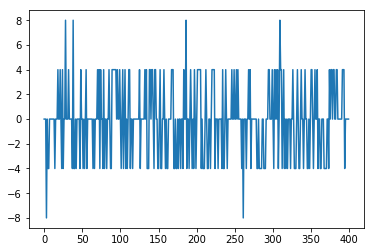

In [28]:
import matplotlib.pyplot as plt
plt.plot(magnet)

## Configuration space after 1100 Tight binding model iterations in a 2x2x2 supercell

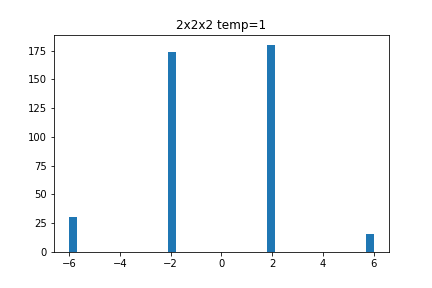

In [7]:
from IPython.display import Image
Image("2x2x2_temp=1.png")